# **Feature computation**

#### **0. Quick data analysis**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [ ]:
df = pd.read_csv("spark_dataset.csv", sep=";")
df.head()

,date,servicePoint,volume_l_value
0,21/10/2024,112637,0.0
1,20/10/2024,112637,0.0
2,21/10/2024,100732,0.0
3,19/10/2024,112637,0.0
4,18/10/2024,112637,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            885 non-null    object 
 1   servicePoint    885 non-null    int64  
 2   volume_l_value  885 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.9+ KB


- 885 rows
- 3 columns
  - `date`: the current date (should be converted in pandas date format)
  - `servicePoint`: the meter service point (there are 3 in the dataset)
  - `volume_l_value`: the volume of watter consumed per day (in liters?)
- No missing value

In [4]:
# Date convertion
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")

In [ ]:
# Q: Do the service points have the same number of data?
df.groupby(["servicePoint"]).size()

# A: Yes

servicePoint
21827     295
100732    295
112637    295
dtype: int64

In [6]:
# Q: Then we assume that we have one data point per date and per service point. Is that True?
(df.groupby(["servicePoint", "date"]).size() == 1).all()

# A: Yes

np.True_

In [7]:
# Q: Were the data recorded on the same days for all service points?
df["date"].nunique()

# A: Yes

295

In [8]:
# Q: Are those days consecutive?
df["date"].drop_duplicates().sort_values().diff().unique()

# A: Yes

<TimedeltaArray>
[NaT, '1 days']
Length: 2, dtype: timedelta64[ns]

In [9]:
# Q: What's the data collection period?
df["date"].min(), df["date"].max()

# A: From Jan 01, 2024 to Oct 21, 2024

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-10-21 00:00:00'))

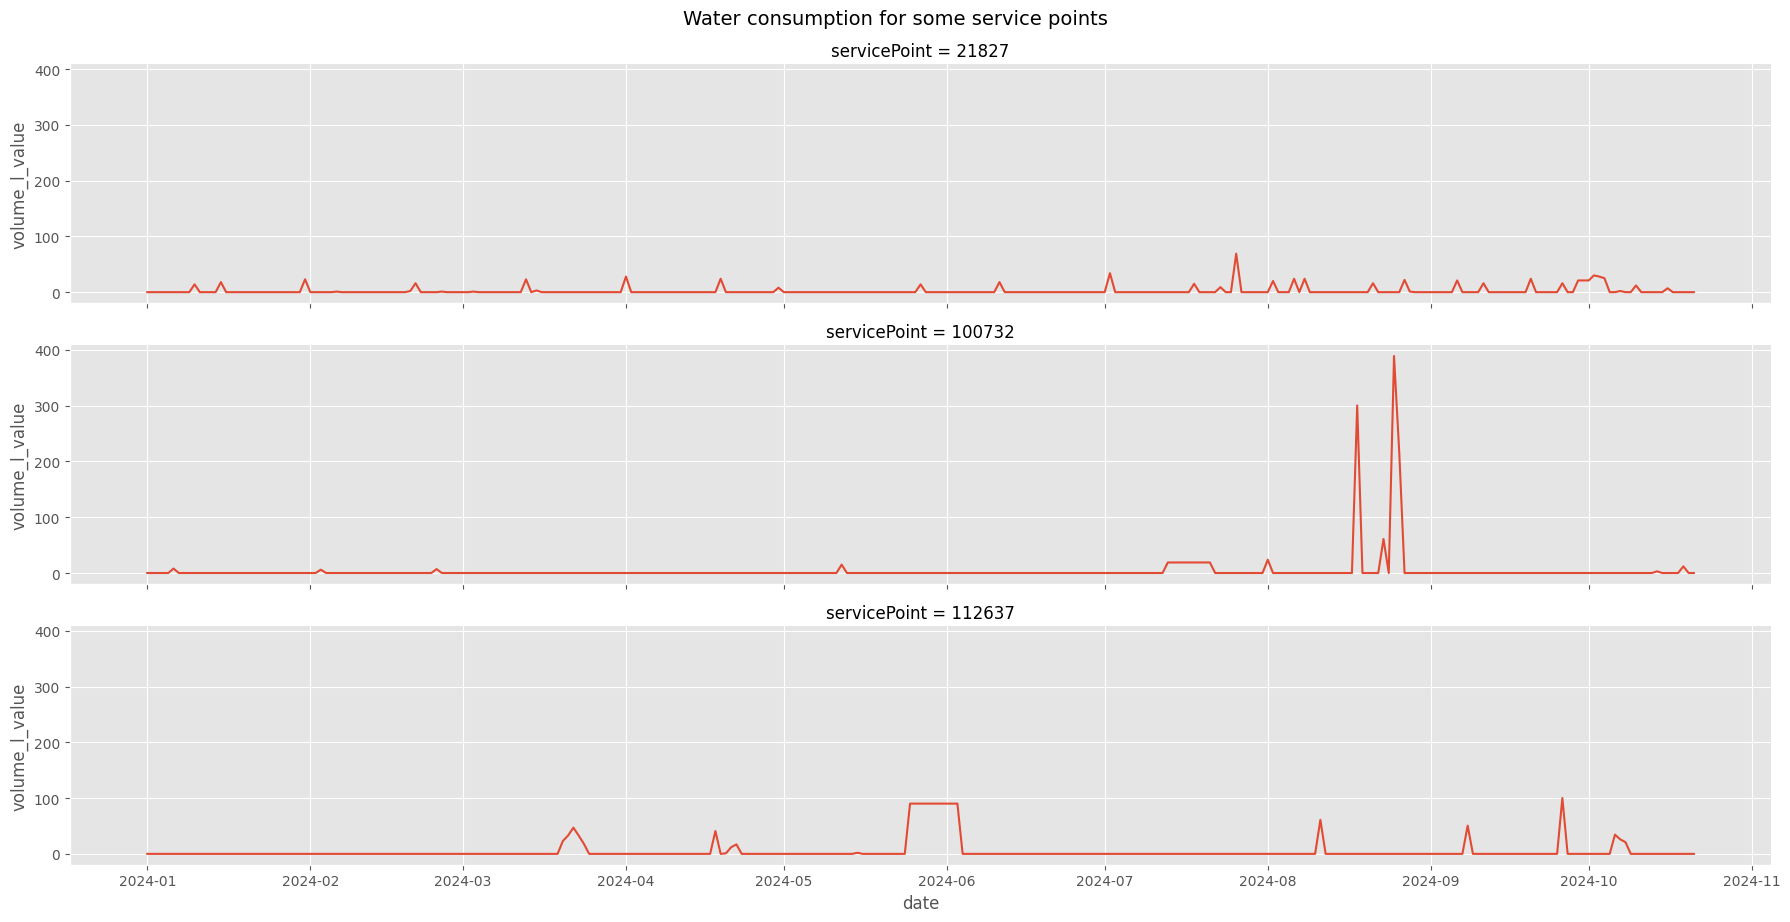

In [10]:
# The data is perfectly aligned, we can easily visualize them
sns.relplot(
    df, x="date", y="volume_l_value", row="servicePoint",
    kind="line", height=3, aspect=6
)
plt.suptitle("Water consumption for some service points", y=1.02, fontsize=14)
plt.show()

In [11]:
# We want to sort and split the data before processing it
# -> The index is reset so that each row "n" is followed by the row "n+1"
# -> This will be helpful for answering the questions
df.sort_values(["servicePoint", "date"], ignore_index=True, inplace=True)

# Service point indexes for filtering
sp_1 = df[df["servicePoint"] == 21827].index
sp_2 = df[df["servicePoint"] == 100732].index
sp_3 = df[df["servicePoint"] == 112637].index

#### **1. Compute `v1`**

- `v1` represents the elapsed time without consumption, i.e the difference between day of analysis and last day with significant consumption (> 20 liters) for 2 consecutive days (consider each service point alone)
- Definition: We denote To the last day of consumption according to the definition above and T the current
day. We then have v1 = T - To

In [12]:
# Days with significant consumption (> 20 liters)
df["vol>20"] = df["volume_l_value"] > 20

# Consecutive significant consumptions (T0)
# -> This is determined by creating a lagged version of the column `vol>20`
# -> The T0s are the days for which (`vol>20` == 1) and (`vol>20_lag` == 1)

# We should process each service point separately when shifting the data
df.loc[sp_1, "vol>20_lag"] = df.loc[sp_1, "vol>20"].shift()
df.loc[sp_2, "vol>20_lag"] = df.loc[sp_2, "vol>20"].shift()
df.loc[sp_3, "vol>20_lag"] = df.loc[sp_3, "vol>20"].shift()

# Compute T0
df["T0"] = (df["vol>20"] & df["vol>20_lag"])

# Get T0s for each service point
T0 = df[df["T0"] == 1].index
T0_1 = T0.intersection(sp_1)
T0_2 = T0.intersection(sp_2)
T0_3 = T0.intersection(sp_3)

In [13]:
def compute_v1(row_id, T0):
    # Compare each row id to the array of T0s
    days_diff = row_id - T0
    
    # Days before the observation
    days_before = days_diff[np.where(days_diff >= 0)[0]]
    
    if len(days_before) > 0:
        # The nearest T0 day before the observation
        v1 = days_before[-1]
    else:
        # We don't have the information
        v1 = np.nan
    return v1

In [14]:
# Execute the function for each service point
v1_1 = sp_1.to_series().apply(lambda row_id: compute_v1(row_id, T0_1))
v1_2 = sp_2.to_series().apply(lambda row_id: compute_v1(row_id, T0_2))
v1_3 = sp_3.to_series().apply(lambda row_id: compute_v1(row_id, T0_3))

# Add v1 to the dataset
df["v1"] = pd.concat([v1_1, v1_2, v1_3])

In [15]:
# Display
df.iloc[270:280]

,date,servicePoint,volume_l_value,vol>20,vol>20_lag,T0,v1
270,2024-09-27,21827,0.0,False,False,False,NaN
271,2024-09-28,21827,0.0,False,False,False,NaN
272,2024-09-29,21827,21.0,True,False,False,NaN
273,2024-09-30,21827,21.0,True,True,True,0.0
274,2024-10-01,21827,21.0,True,True,True,0.0
275,2024-10-02,21827,30.0,True,True,True,0.0
276,2024-10-03,21827,28.0,True,True,True,0.0
277,2024-10-04,21827,25.0,True,True,True,0.0
278,2024-10-05,21827,0.0,False,True,False,1.0
279,2024-10-06,21827,0.0,False,False,False,2.0


#### **2. Compute `v2`**

- `v2` describes the non-zero consumption rate over 90 days before To
- We assume To is always the current day, and not the To from the previous exercice
- If we want to focus on previous To only, we can easily filter the dataset accordingly

In [16]:
def compute_v2(row_id, lower_bound, upper_bound):
    # 90-days interval
    ids_90 = range(row_id - 90, row_id)
    
    # Interval check
    if (ids_90[0] < lower_bound) | (ids_90[0] > upper_bound):
        return np.nan
    
    # Number of days with a noticed consumption
    non_zero_cons = (df.iloc[ids_90]["volume_l_value"] > 0).sum()
    
    # v2 rate
    v2 = non_zero_cons / 90
    
    return v2

In [17]:
# Execute the function for each service point
v2_1 = sp_1.to_series().apply(lambda row_id: compute_v2(row_id, sp_1[0], sp_1[-1]))
v2_2 = sp_2.to_series().apply(lambda row_id: compute_v2(row_id, sp_2[0], sp_2[-1]))
v2_3 = sp_3.to_series().apply(lambda row_id: compute_v2(row_id, sp_3[0], sp_3[-1]))

# Add v2 to the dataset
df["v2"] = pd.concat([v2_1, v2_2, v2_3])

In [18]:
# Display
df.drop(columns=["v1", "vol>20", "vol>20_lag", "T0"]).iloc[270:280]

,date,servicePoint,volume_l_value,v2
270,2024-09-27,21827,0.0,0.155556
271,2024-09-28,21827,0.0,0.155556
272,2024-09-29,21827,21.0,0.155556
273,2024-09-30,21827,21.0,0.166667
274,2024-10-01,21827,21.0,0.166667
275,2024-10-02,21827,30.0,0.177778
276,2024-10-03,21827,28.0,0.188889
277,2024-10-04,21827,25.0,0.200000
278,2024-10-05,21827,0.0,0.211111
279,2024-10-06,21827,0.0,0.211111


#### **3. Results**

In [19]:
df.drop(columns=["vol>20", "vol>20_lag", "T0"], inplace=True)
df.iloc[270:280]

,date,servicePoint,volume_l_value,v1,v2
270,2024-09-27,21827,0.0,NaN,0.155556
271,2024-09-28,21827,0.0,NaN,0.155556
272,2024-09-29,21827,21.0,NaN,0.155556
273,2024-09-30,21827,21.0,0.0,0.166667
274,2024-10-01,21827,21.0,0.0,0.166667
275,2024-10-02,21827,30.0,0.0,0.177778
276,2024-10-03,21827,28.0,0.0,0.188889
277,2024-10-04,21827,25.0,0.0,0.200000
278,2024-10-05,21827,0.0,1.0,0.211111
279,2024-10-06,21827,0.0,2.0,0.211111
